In [1]:
# Location of the csv for analysis
pathToData  = '/Users/adam.evans/Desktop/KatieClean/'
filename = 'KatieData.csv'

#################

import csv
import numpy as np
import pandas as pd
from itertools import izip
import re

# regular expressions *winky face*
fmNumRE = re.compile('.*fm(\d+)')
weekRE = re.compile('.*week(\d+)')
tsLineRE = re.compile('intern_supervisor_form_.*_timestamp')
completeRE = re.compile('intern_supervisor_form_.*_complete')

def readKatieData(ogData):

    # declare the list we add each survey question to
    event = []

    # start the week counter
    weekIndex = 0

    # iterate through rows
    for i, entry in enumerate(ogData):

        qt = entry[0] # this is the variable code

        if tsLineRE.match(qt) != None:
            if entry[2]=='': # if there is an incomplete week
                break # stop reading the data

        if re.match('.*survey_identifier.*',qt) != None:
            surveyIdentifier = entry[2]
        elif re.match('record_id',qt) != None:
            recordID = entry[2]
        elif tsLineRE.match(qt) != None: # this is the week beginning
            weekIndex = weekIndex + 1
            ts = entry[2]
            # print 'Survey Timestamp ' + ts
        elif fmNumRE.match(qt) != None:

            # find the form number
            fmNumMatch = fmNumRE.match(qt)
            fmNum = int(fmNumMatch.group(1))

            # determine the event type ignoring night 1 and 2
            eventType = entry[1]
            gsMatch = re.match('^Group Supervision', eventType)
            if gsMatch != None:
                eventType = gsMatch.group(0)
            gdMatch = re.match('^Group Dinner', eventType)
            if gdMatch != None:
                eventType = gdMatch.group(0)

            # put together relevant data row
            score = entry[2]
            newEvent = [weekIndex, fmNum, eventType, score]

            event.append(newEvent)

        elif completeRE.match(qt) != None:
            completedWeek = completeRE.match(qt).group(0)
            weekMatch = weekRE.match(completedWeek)
            if (weekMatch != None) and (entry[2] != ''):
                weekNum = weekMatch.group(1)
                # print 'Week ' + weekNum + ' completed'
    
    return event

def print4XL(event):
    
    # create dataframe
    eventDF = pd.DataFrame(event, columns= ['weekIndex', 'fmNum', 'eventType', 'score'])
    
    # print event
    eventDF.to_csv(pathToData+'EventByWeek.csv')
    
    # print numeric only event
    
    # print pivot

# open and transpose data
ogData = izip(*csv.reader(open(pathToData+filename, "rU")))

# normalize data
event = readKatieData(ogData)

# create dataframe
eventDF = pd.DataFrame(event, columns= ['weekIndex', 'fmNum', 'eventType', 'score'])

# filter to numeric rows
numericOnly = eventDF['score'].isin(['0','1','2','3','4','5'])
eventDF = eventDF[numericOnly]

# cast as a number instead of a string
eventDF[['score']] = eventDF[['score']].astype(float)
# eventDF.head(60)

df = eventDF

In [2]:
scoreFreq = df['score'].value_counts() 
print scoreFreq.sort_index()

0     27
1    243
2     69
3      2
4      5
5      4
dtype: int64


In [3]:
# import re
# fmString = ['ch15_isfm23_week45','ch15_isfm4']
# fmNumRE = re.compile('.*fm(\d+)')

# for s in fmString:
#     fmNumMatch = fmNumRE.match(s)
#     if fmNum != None:
#         fmNum = fmNumMatch.group(1)
#         print fmNum
        
# # not useful except for qc
# qt = 'intern_supervisor_form_chicago_week1454_timestamp'
# tsLineRE = re.compile('intern_supervisor_form_.*_timestamp')
# tsRE = re.compile('.*week(\d+)')
# tsLine = tsLineRE.match(qt)
# if tsLine != None:
#     ts = tsRE.match(tsLine.group(0))
#     weekNum = ts.group(1)
#     print weekNum

# df.dtypes
# [row for row in event if row[3].isdigit()] !!list comprehension

In [4]:
s = 'Group Supervision'
gsMatch = re.match('^Group Supervision', s)
if gsMatch != None:
    gs = gsMatch.group(0)
    print gs

#re.match(pattern, string)


Group Supervision


In [5]:
df.mean()

weekIndex     4.00
fmNum        34.34
score         1.22
dtype: float64

In [6]:
g = df.groupby(['weekIndex','eventType'])
m = pd.DataFrame(g['score'].mean())
print m.unstack()


                          score                                        \
eventType Clinical Team Meeting Dinner Group Dinner Group Supervision   
weekIndex                                                               
1                             1  1.000          1.0               1.1   
2                             2  1.125          1.0               1.1   
3                             1  1.000          1.0               1.0   
4                             1  1.125          1.0               1.1   
5                             1  1.000          1.0               1.0   
6                             1  1.125          0.5               1.0   
7                             1  1.125          1.0               1.1   

                                                                                  \
eventType How useful did the mentors find the Intern Seminar or Case Conference?   
weekIndex                                                                          
1                

In [7]:
g = df.groupby(['weekIndex'])
weekMean = g['score'].mean()
print weekMean
# what happened in weeks 6 and 7 ??

weekIndex
1    1.24
2    1.22
3    1.28
4    1.18
5    1.22
6    1.04
7    1.36
Name: score, dtype: float64


In [8]:
g = df.groupby(['eventType'])
eventMean = g['score'].mean()
# need pattern to match Group Dinner
# need pattern to match Group Supervision
print eventMean

eventType
Clinical Team Meeting                                                     1.142857
Dinner                                                                    1.071429
Group Dinner                                                              0.928571
Group Supervision                                                         1.057143
How useful did the mentors find the Intern Seminar or Case Conference?    4.428571
Individual Supervision                                                    0.946429
Intern Seminar                                                            1.015873
Sparks Meeting                                                            1.523810
Was an Intern Seminar or Case Conference held this week?                  1.000000
Who presented at the Intern Seminar or Case Conference?                   3.000000
Name: score, dtype: float64


In [9]:
bigL = eventMean > 2
print eventMean[bigL]
# are these on a different scale??

eventType
How useful did the mentors find the Intern Seminar or Case Conference?    4.428571
Who presented at the Intern Seminar or Case Conference?                   3.000000
Name: score, dtype: float64


In [10]:
print eventMean[-bigL]

eventType
Clinical Team Meeting                                       1.142857
Dinner                                                      1.071429
Group Dinner                                                0.928571
Group Supervision                                           1.057143
Individual Supervision                                      0.946429
Intern Seminar                                              1.015873
Sparks Meeting                                              1.523810
Was an Intern Seminar or Case Conference held this week?    1.000000
Name: score, dtype: float64


In [11]:
# DYING FOR A BAR CHART



In [12]:
numericOnly = df['score'].isin(['0','1','2','3','4','5'])
# bool??

In [13]:
df.dtypes
#g = df.groupby(['weekindex','eventType'])
#eventMean = g['score'].mean()
#eventMean.pivot('weekIndex', 'eventType')['score']


weekIndex      int64
fmNum          int64
eventType     object
score        float64
dtype: object

In [15]:
m.to_csv(pathToData+'EventByWeek.csv')

In [16]:
pathToData+'EventByWeek.csv'

'/Users/adam.evans/Desktop/KatieClean/EventByWeek.csv'

In [59]:
edf = df# denormalize for excel
g = edf.groupby(['weekIndex'])
m = pd.DataFrame(g['score'].mean())
print m
# denorm = m.unstack()
# denorm.to_csv(pathToData+'EventByWeek.csv', sep=',', index=True, header=True)

           score
weekIndex       
1           1.24
2           1.22
3           1.28
4           1.18
5           1.22
6           1.04
7           1.36


In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

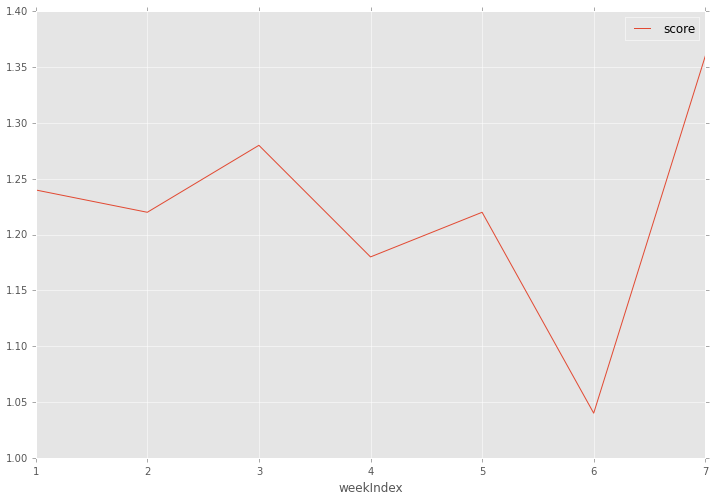

In [61]:
# m is score by week
m.plot(figsize=(12,8))